In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
'''

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Merge
from keras.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates
import datetime

In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '2009-01-01', '2011-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_0

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     0  2009-01-02  78.738477  227566300
1     1  2009-01-05  78.645305  240349700
2     2  2009-01-06  79.170456  328260900
3     3  2009-01-07  76.798813  280899200
4     4  2009-01-08  77.112211  263834400
---
     Item        Date   Adj_Close     Volume
615   615  2011-06-13  113.330427  207599800
616   616  2011-06-14  114.768144  160570400
617   617  2011-06-15  112.726945  300958000
618   618  2011-06-16  112.975443  308032800
619   619  2011-06-17  113.312574  233284900


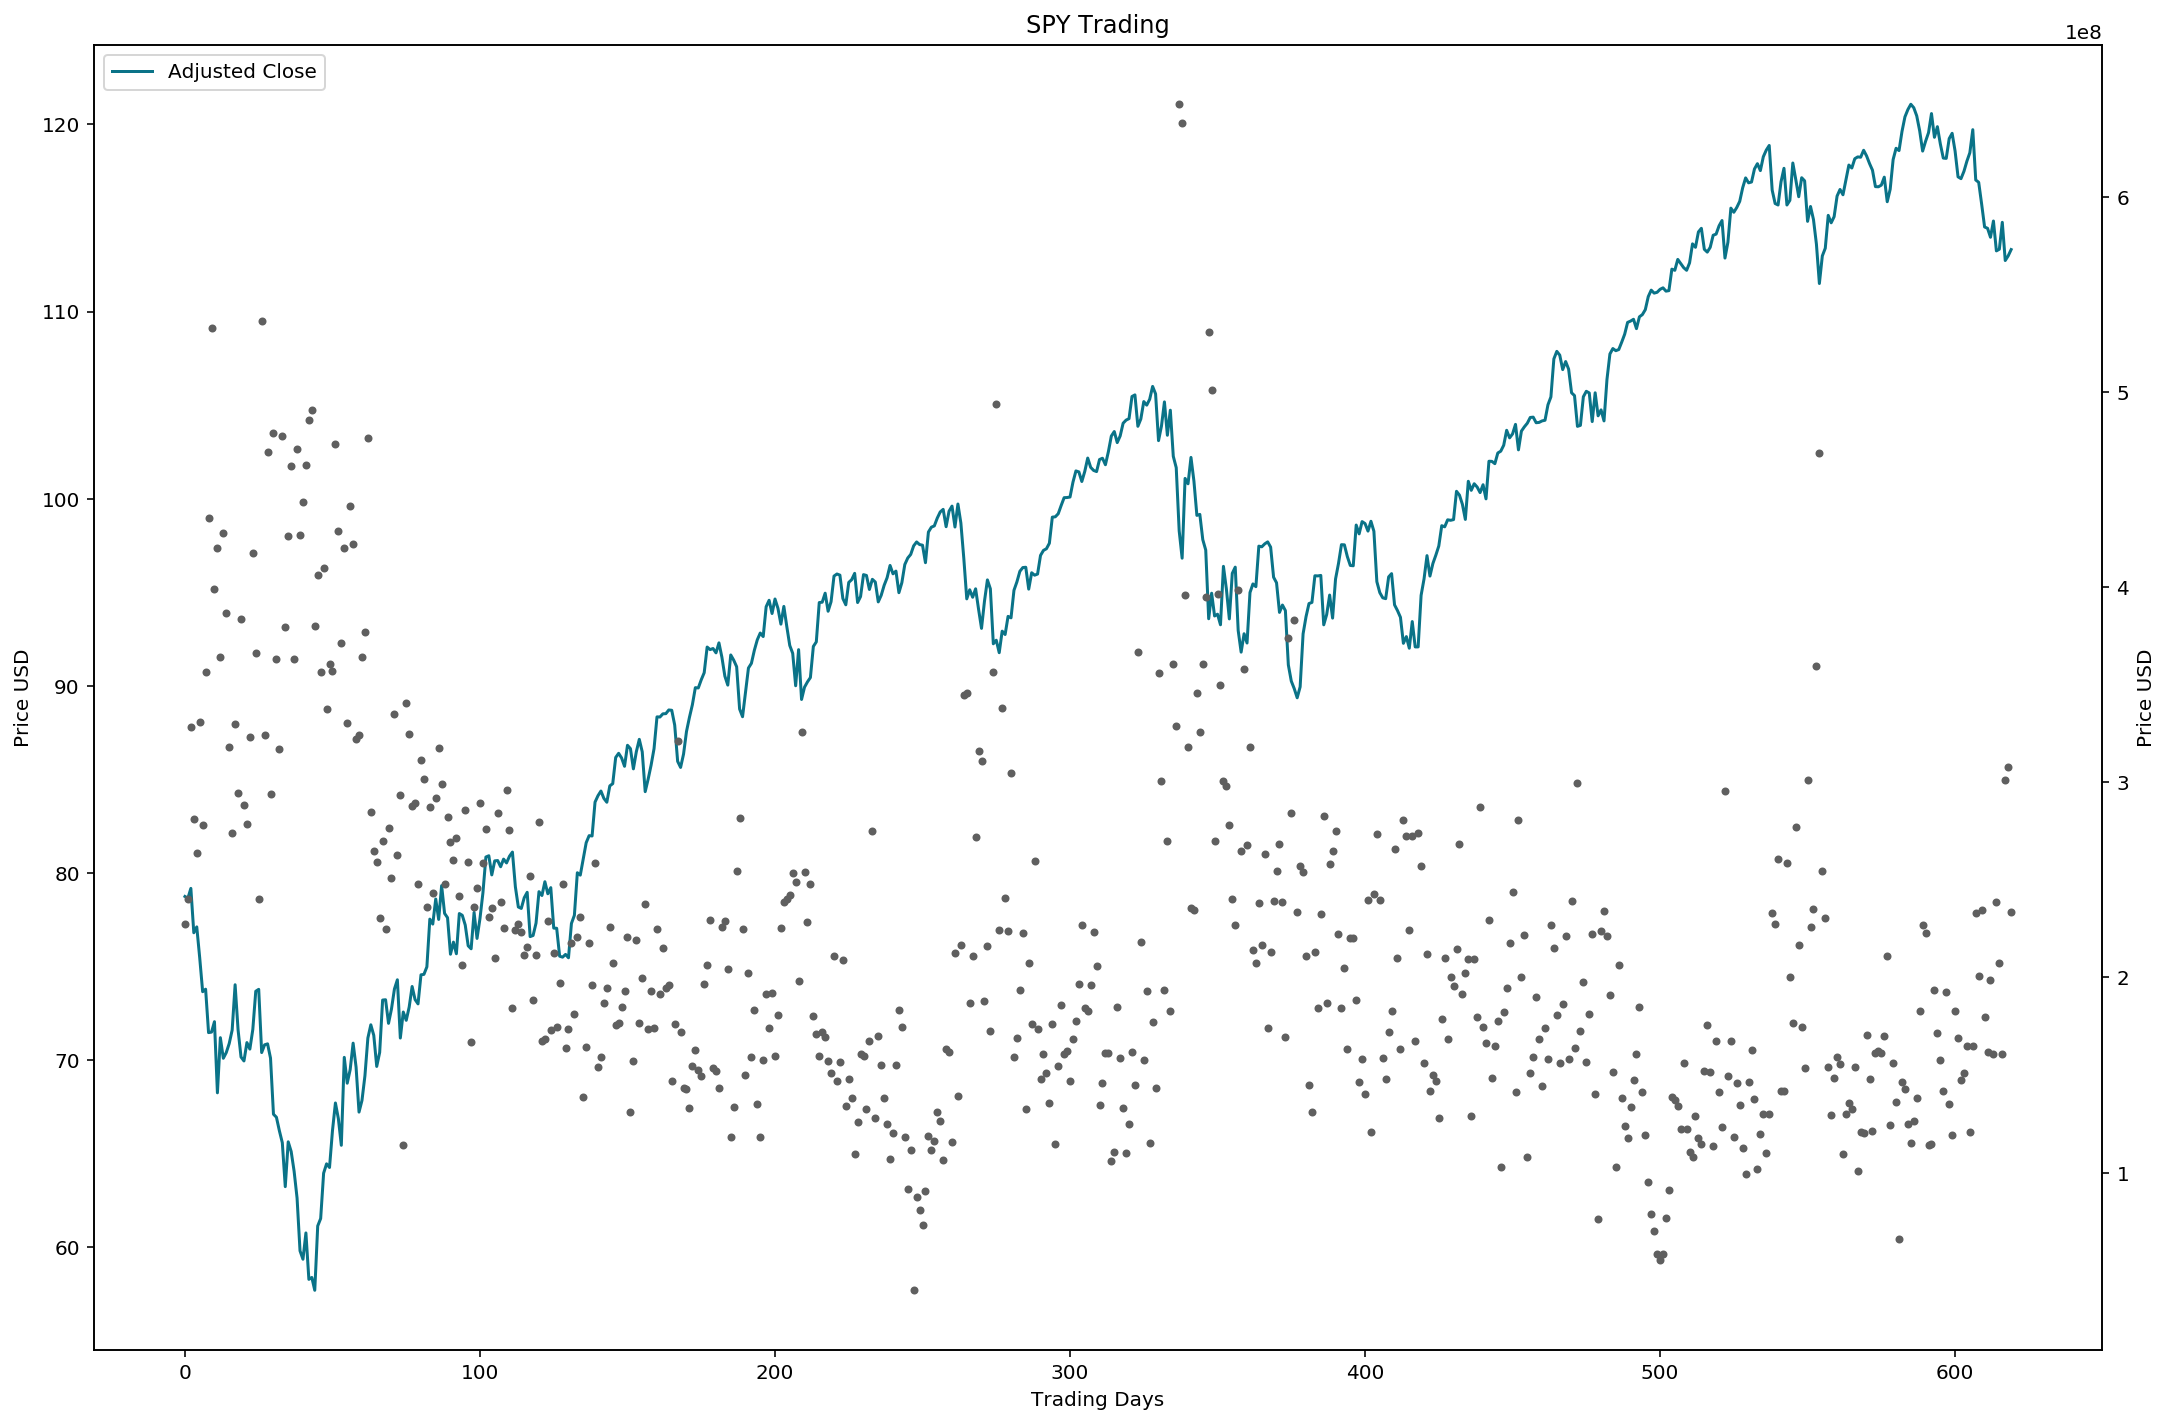

In [11]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')

plt.show()

In [12]:
#Create numpy arrays for features and targets
X_day_all = []
X_vol_all = []
y_close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_day_all.append([(row['Item'])])
    X_vol_all.append([(row['Volume'])])
    y_close_all.append([(row['Adj_Close'])])

#pprint(X_all)
pprint(y_close_all)

[[78.738477],
 [78.64530500000001],
 [79.170456],
 [76.798813],
 [77.112211],
 [75.460528],
 [73.647917],
 [73.783443],
 [71.462625],
 [71.488034],
 [72.04706],
 [68.243967],
 [71.19158],
 [70.090459],
 [70.39538399999999],
 [70.878182],
 [71.59814399999999],
 [74.020606],
 [71.615088],
 [70.158221],
 [69.94646800000001],
 [70.929001],
 [70.58172900000001],
 [71.632025],
 [73.673333],
 [73.774971],
 [70.39538399999999],
 [70.81042],
 [70.861245],
 [70.09893100000001],
 [67.100498],
 [66.939563],
 [66.21960200000001],
 [65.575869],
 [63.229642000000005],
 [65.626695],
 [65.110015],
 [64.051247],
 [62.61979],
 [59.79923],
 [59.350313],
 [60.756361],
 [58.274606999999996],
 [58.376245],
 [57.690165],
 [61.129043],
 [61.52714],
 [63.949603],
 [64.449338],
 [64.254529],
 [66.21960200000001],
 [67.70187800000001],
 [66.86333499999999],
 [65.439545],
 [70.140001],
 [68.758014],
 [69.48312800000001],
 [70.899239],
 [69.619624],
 [67.21394699999999],
 [67.836689],
 [69.150429],
 [71.172224],
 [

In [13]:
# Scale function
def scale_range(X, input_range=[0.0,1.0], target_range=[0.0,1.0]):
    """
    Scales a numpy array to a new target range
    X = array of numbers
    target_range = new target min and max, default (0.0, 1.0)
    """
    orig_range = [X.min(axis=0),X.max(axis=0)]
    orig_range = [orig_range[0][0], orig_range[1][0]]
    X_std = (X - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    X_scaled = X_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return X_scaled, orig_range
    

In [14]:
# Regularize the feature and target arrays and store min/max of input data for rescaling later
X_day_bounds = [min(X_day_all), max(X_day_all)]
X_day_bounds = [X_day_bounds[0][0], X_day_bounds[1][0]]
X_vol_bounds = [min(X_vol_all), max(X_vol_all)]
X_vol_bounds = [X_vol_bounds[0][0], X_vol_bounds[1][0]]
y_close_bounds = [min(y_close_all), max(y_close_all)]
y_close_bounds = [y_close_bounds[0][0], y_close_bounds[1][0]]

X_day_scaled, X_day_range = scale_range(np.array(X_day_all), input_range=X_day_bounds)
X_vol_scaled, X_vol_range = scale_range(np.array(X_vol_all), input_range=X_vol_bounds)
y_close_scaled, y_close_range = scale_range(np.array(y_close_all), input_range=y_close_bounds)

pprint(y_close_scaled)
print(y_close_range)

array([[ 0.33205564],
       [ 0.33058577],
       [ 0.33887049],
       [ 0.30145574],
       [ 0.30639987],
       [ 0.28034311],
       [ 0.25174758],
       [ 0.25388562],
       [ 0.21727268],
       [ 0.21767353],
       [ 0.22649265],
       [ 0.16649551],
       [ 0.2129967 ],
       [ 0.19562555],
       [ 0.20043601],
       [ 0.20805257],
       [ 0.21941061],
       [ 0.25762708],
       [ 0.21967791],
       [ 0.19669456],
       [ 0.19335397],
       [ 0.20885429],
       [ 0.20337577],
       [ 0.21994511],
       [ 0.25214854],
       [ 0.25375197],
       [ 0.20043601],
       [ 0.20698357],
       [ 0.20778538],
       [ 0.1957592 ],
       [ 0.14845628],
       [ 0.14591739],
       [ 0.13455937],
       [ 0.12440392],
       [ 0.08739012],
       [ 0.12520575],
       [ 0.11705466],
       [ 0.10035167],
       [ 0.07776917],
       [ 0.03327236],
       [ 0.0261903 ],
       [ 0.04837194],
       [ 0.00922009],
       [ 0.01082352],
       [ 0.        ],
       [ 0

In [15]:
# Define Test/Train Split 80/20
tt_split = .20
tti_split = int(math.floor(len(stock_df['Item'])*tt_split))

# Set up training and test sets
X_day_train = X_day_scaled[:-tti_split]
X_day_test = X_day_scaled[-tti_split:]
#pprint(X_day_train)
#print(len(X_day_test))

X_vol_train = X_vol_scaled[:-tti_split]
X_vol_test = X_vol_scaled[-tti_split:]
#pprint(X_vol_train)
#print(len(X_vol_test))

y_close_train = y_close_scaled[:-tti_split]
y_close_test = y_close_scaled[-tti_split:]


# Create dataframe for all training, testing, and predicted sets
results_df = pd.DataFrame(columns=['Item', 'Close', 'Close_Scaled', 'Close_Train', 'Close_Test', 'Close_Test_Scaled', 'Close_Predicted', 'Close_Predicted_Scaled'])
results_df['Item'] = stock_df['Item']
results_df['Close'] = stock_df['Adj_Close']
results_df['Close_Scaled'] = y_close_scaled.flatten()
results_df['Close_Train'][:-tti_split] = y_close_train.flatten()
results_df['Close_Test'][-tti_split:] = stock_df['Adj_Close'][-tti_split:]
results_df['Close_Test_Scaled'][-tti_split:] = y_close_test.flatten()

pprint(results_df)


     Item       Close  Close_Scaled Close_Train Close_Test Close_Test_Scaled  \
0       0   78.738477      0.332056    0.332056        NaN               NaN   
1       1   78.645305      0.330586    0.330586        NaN               NaN   
2       2   79.170456      0.338870     0.33887        NaN               NaN   
3       3   76.798813      0.301456    0.301456        NaN               NaN   
4       4   77.112211      0.306400      0.3064        NaN               NaN   
5       5   75.460528      0.280343    0.280343        NaN               NaN   
6       6   73.647917      0.251748    0.251748        NaN               NaN   
7       7   73.783443      0.253886    0.253886        NaN               NaN   
8       8   71.462625      0.217273    0.217273        NaN               NaN   
9       9   71.488034      0.217674    0.217674        NaN               NaN   
10     10   72.047060      0.226493    0.226493        NaN               NaN   
11     11   68.243967      0.166496    0

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [36]:
# Reshape into t and t+1
look_back = 3
X_day_train_t, X_day_train_t1 = create_dataset(X_day_train, look_back)
X_vol_train_t, X_vol_train_t1 = create_dataset(X_vol_train, look_back)
y_close_train_t, y_close_train_t1 = create_dataset(y_close_train, look_back)
y_close_test_t, y_close_test_t1 = create_dataset(y_close_test, look_back)

pprint(X_day_train_t)
print('--')
#pprint(trainY)

# Reshape input to be [samples, time steps, features]
X_day_train_t = np.reshape(X_day_train_t, (X_day_train_t.shape[0], X_day_train_t.shape[1], 1))
X_vol_train_t = np.reshape(X_vol_train_t, (X_vol_train_t.shape[0], X_vol_train_t.shape[1], 1))
y_close_train_t = np.reshape(y_close_train_t, (y_close_train_t.shape[0], y_close_train_t.shape[1], 1))
y_close_test_t = np.reshape(y_close_test_t, (y_close_test_t.shape[0], y_close_test_t.shape[1], 1))

pprint(X_day_train_t)
print('--')
#pprint(testX)

array([[ 0.        ,  0.00161551,  0.00323102],
       [ 0.00161551,  0.00323102,  0.00484653],
       [ 0.00323102,  0.00484653,  0.00646204],
       ..., 
       [ 0.78998384,  0.79159935,  0.79321486],
       [ 0.79159935,  0.79321486,  0.79483037],
       [ 0.79321486,  0.79483037,  0.79644588]])
--
array([[[ 0.        ],
        [ 0.00161551],
        [ 0.00323102]],

       [[ 0.00161551],
        [ 0.00323102],
        [ 0.00484653]],

       [[ 0.00323102],
        [ 0.00484653],
        [ 0.00646204]],

       ..., 
       [[ 0.78998384],
        [ 0.79159935],
        [ 0.79321486]],

       [[ 0.79159935],
        [ 0.79321486],
        [ 0.79483037]],

       [[ 0.79321486],
        [ 0.79483037],
        [ 0.79644588]]])
--


In [39]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

#TODO - Add Embeddings
# Create and fit the LSTM network
batch_size = 1
epochs = 10 # 200
# Create LSTM Day network
model1 = Sequential()
model1.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1)))
model1.add(Dense(1))
# Create LSTM Volume network
model2 = Sequential()
model2.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1)))
model2.add(Dense(1))

# Create Merged Model
merged_model = Merge([model1, model2], mode='dot', concat_axis=1)

# Create final composite model
final_model = Sequential()
final_model.add(merged_model)
final_model.add(Dense(1))
final_model.compile(loss='mean_squared_error', optimizer='adam')

# Format inputs
inputs = [X_day_train, X_vol_train]
final_model.fit(inputs, y_close_train, nb_epoch=epochs, batch_size=batch_size, verbose=2, shuffle=False)


Exception: Error when checking model input: expected lstm_input_41 to have 3 dimensions, but got array with shape (496, 1)

In [ ]:
# Generate predictions for training
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict_rescaled, r1 = scale_range(np.array(trainPredict), input_range=[0.0, 1.0], target_range=y_bounds)
testPredict_rescaled, r2 = scale_range(np.array(testPredict), input_range=[0.0, 1.0], target_range=y_bounds)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_rescaled)+look_back, :] = trainPredict_rescaled
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_rescaled)+(look_back*2)+1:len(X_scaled)-1, :] = testPredict_rescaled

# Create actual values in aligned array
yPlot = np.empty_like(y_scaled)
yPlot[:, :] = np.nan
yPlot[-len(testPredict_rescaled):, :] = y_all[-len(testPredict_rescaled):]

# plot baseline and predictions
plt.plot(yPlot,'#5F5F5F')
plt.plot(testPredictPlot,  '#0C91AB')
plt.show()

In [ ]:
# The mean squared error
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

# Log of Results:
Lookback: 3

### SPY
Mean squared error: 0.0003

-- to process --

### GE
Mean squared error: 0.002


### MSFT
Mean squared error: 0.005


### AAPL
Mean squared error: 0.002

